In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from itertools import combinations
import seaborn as sns
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from c45 import C45
from sklearn.manifold import MDS

# splite continuous and categorical data for further analysis

In [2]:
data = pd.read_excel("tr.xlsx")

In [3]:
np.sort(data.nunique().unique())

array([  2,   3,   4,   6,  14,  16,  58,  86, 103, 109, 132, 170, 205,
       206, 229, 245, 274, 299, 316, 339, 350, 381, 428, 514, 516, 570,
       852], dtype=int64)

In [4]:
data_conti = data.iloc[:,np.where(data.nunique()>20)[0]]
data_cat = data.iloc[:,np.where(data.nunique()<=20)[0]]
target = data_cat.iloc[:,0]
data_cat = data_cat.iloc[:,1:]

In [5]:
data_conti = data_conti.fillna(data_conti.mean())

for i in range(data_cat.shape[1]):
    data_cat.iloc[:,i] = data_cat.iloc[:,0].fillna(data_cat.mode().to_numpy()[0][0])

data_cat = pd.get_dummies(data_cat, columns = data_cat.columns, drop_first = True)

In [6]:
embedding = MDS(n_components=2)
data_trans= embedding.fit_transform(data_conti)
data_trans.shape

MemoryError: Unable to allocate 20.3 GiB for an array with shape (52159, 52159) and data type float64

In [ ]:
plt.plot(data_trans[:,0])
plt.plot(data_trans[:,1])

In [5]:
data[data.columns[data.nunique()==16]].value_counts()

cci_index
0            35002
1             8003
2             4343
3             2301
4             1172
5              656
6              289
8              131
7              117
9               84
10              29
11              13
12              12
13               4
14               2
15               1
dtype: int64

# Delete continuous data with NA value over 30% (paper supported)

In [6]:
print(data_conti.columns[np.where((data_conti.isnull().sum()/len(data))<0.3)])
data_conti = data_conti[data_conti.columns[np.where((data_conti.isnull().sum()/len(data))<0.3)]]

Index(['AGE', 'LOS'], dtype='object')


# Examine proportion of outcome

In [7]:
data["outcome"].value_counts()

0    51280
1      879
Name: outcome, dtype: int64

# Continuous data EDA

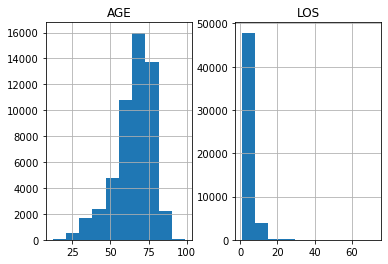

In [8]:
data_conti.hist()
plt.show()

In [9]:
data_conti.LOS = np.log(data_conti.LOS)

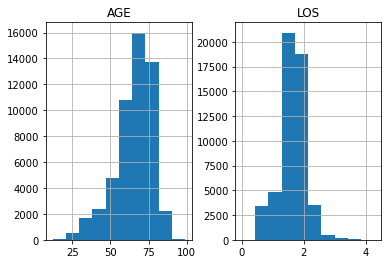

In [10]:
data_conti.hist()
plt.show()

In [11]:
data_conti.corr()

,AGE,LOS
AGE,1.000000,0.030688
LOS,0.030688,1.000000


# Standardization on continuous data

In [12]:
data_conti = (data_conti - data_conti.mean())/data_conti.std()

# Chi square for categorical data

In [13]:
def del_cat(pd_data_cat):
    comb = combinations([i for i in range(pd_data_cat.shape[1])],2)
    comb = list(comb)

    chi_re = []
    for i in comb:
        re = []
        re.append(pd_data_cat.columns[i[0]])
        re.append(pd_data_cat.columns[i[1]])
        re.append(chi2_contingency(np.array(pd.crosstab(pd_data_cat.iloc[:,i[0]], pd_data_cat.iloc[:,i[1]])))[1])
        chi_re.append(re)

    cat_col = pd_data_cat.columns
    cat_count = np.array([0 for i in range(len(cat_col))])

    for i in chi_re:
        if i[2] < 0.05:
            cat_count[np.where(cat_col == i[0])[0]] += 1
            cat_count[np.where(cat_col == i[1])[0]] += 1
            
    return pd_data_cat.drop([cat_col[np.argmax(cat_count)]],axis=1)

def chi_2(pd_data_cat):
    comb = combinations([i for i in range(pd_data_cat.shape[1])], 2)
    comb = list(comb)
    chi_re = []
    for i in comb:
        re = []
        re.append(pd_data_cat.columns[i[0]])
        re.append(pd_data_cat.columns[i[1]])
        re.append(chi2_contingency(np.array(pd.crosstab(pd_data_cat.iloc[:,i[0]], pd_data_cat.iloc[:,i[1]])))[1])
        chi_re.append(re)
    cat_col = pd_data_cat.columns
    cat_count = np.array([0 for i in range(len(cat_col))])
    for i in chi_re:
        if i[2] < 0.05:
            cat_count[np.where(cat_col == i[0])[0]] += 1
            cat_count[np.where(cat_col == i[1])[0]] += 1
    
    return cat_count

def oversample(data):
    over_len = len(np.where(data.outcome==0)[0])-len(np.where(data.outcome==1)[0])
    ind = np.random.choice(np.where(data.outcome==1)[0], over_len)
    
    #data_over = data_clean.iloc[np.random.randint(0,len(np.where(data_clean.outcome==1)[0])),:]
    #for _ in range(over_len - 1):
        #data_over = pd.concat([data_over,data_clean.iloc[np.random.randint(0,len(np.where(data_clean.outcome==1)[0])),:]],axis = 1)
    return pd.concat([data.iloc[ind,:], data], axis = 0)

In [14]:
while np.sum(chi_2(data_cat) > 0):
    data_cat = del_cat(data_cat)

In [15]:
del_cat_y = []
for i in range(data_cat.shape[1]):
    chi2_re = chi2_contingency(np.array(pd.crosstab(data_cat.iloc[:,i], target)))[1]
    if chi2_re > 0.05:
        del_cat_y.append(data_cat.columns[i])
        #data_cat_f = data_cat.drop([data_cat.columns[i]],axis = 1)

In [16]:
data_cat_f = data_cat.drop(del_cat_y,axis = 1)

In [17]:
for i in range(data_cat_f.shape[1]):
    print(data_cat_f.iloc[:,i].value_counts())

0    49890
1     2269
Name: Rheumatoid Arthritis/collagen, dtype: int64
0    51541
1      618
Name: Alcohol Abuse, dtype: int64


In [18]:
#one-hot後會讓NA的vecter都是0
#data_cat_onehot = pd.get_dummies(data_cat, columns = data_cat.columns, drop_first = True)

In [18]:
data_clean = pd.concat([target, data_conti, data_cat_f], axis = 1)
#data_clean = data_clean.dropna()

# Impute mean for continuous data

In [19]:
data_clean.isnull().sum()

outcome                           0
AGE                              94
LOS                              94
Rheumatoid Arthritis/collagen     0
Alcohol Abuse                     0
dtype: int64

In [20]:
data_final = data_clean.fillna(0)

# SMOTENC on training data

In [21]:
X = data_final.iloc[:,1:]
Y = data_final.outcome

X_train, X_val, y_train, y_val = train_test_split(X.to_numpy(), Y.to_numpy(), test_size=0.2)

In [28]:
sm = SMOTENC(categorical_features = [i for i in range(2, X.shape[1])])
X_res, y_res = sm.fit_resample(X, Y)

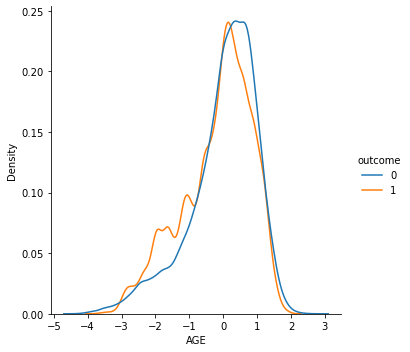

In [33]:
sns.displot(pd.concat([X_res, y_res],axis = 1),x="AGE", kind = "kde", hue ="outcome")

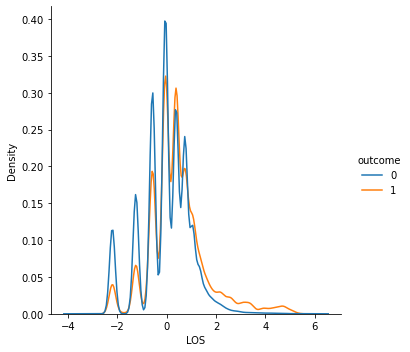

In [34]:
sns.displot(pd.concat([X_res, y_res],axis = 1),x="LOS", kind = "kde", hue ="outcome")

# Output files that linux can run

In [26]:
f= open("name.txt","w")
for n, i in enumerate(data_final.columns):
    f.write(str(i))
    f.write(":")
    if data_final.nunique()[n] == 2:
        f.write("0, 1")
    else:
        f.write("continuous")
    f.write("\n")
f.close()

In [25]:
train = pd.DataFrame(np.append(X_res, y_res.reshape(-1, 1),axis = 1))

val = pd.DataFrame(np.append(X_val, y_val.reshape(-1, 1),axis = 1))

In [30]:
for i in [2, 3, 4, 5, 6, 7, 8]:   #categorical, outcome
    train.iloc[:,i] = train.iloc[:,i].apply(lambda x : int(x))
    val.iloc[:,i] = val.iloc[:,i].apply(lambda x : int(x))

for i in [0, 1]:      #continuous
    train.iloc[:,0] = train.iloc[:,i].apply(lambda x : float(x))
    val.iloc[:,0] = val.iloc[:,i].apply(lambda x : float(x))

In [35]:
train.to_csv("Ian.data", header = False, index = False)
val.to_csv("Ian.test", header = False, index = False)

In [36]:
pd.concat([X_res, y_res],axis = 1).to_csv("train.csv", header = False, index = False)
pd.concat([X_res, y_res],axis = 1).to_csv("train.data", header = False, index = False)
pd.concat([X_res, y_res],axis = 1).to_csv("train.test", header = False, index = False)

# perform same data preprocessing on unknown label testing dataset

In [37]:
test = pd.read_csv("Project#1_ts.csv")

In [38]:
test = test[data_final.columns[1:]]

In [40]:
test.LOS = np.log(test.LOS)

In [41]:
test.iloc[:,[0,1]] = (test.iloc[:,[0,1]] - test.iloc[:,[0,1]].mean())/test.iloc[:,[0,1]].std()

In [42]:
test.isnull().sum()

AGE                              1
LOS                              1
Rheumatoid Arthritis/collagen    0
Alcohol Abuse                    0
dtype: int64

In [43]:
test = test.fillna(0)

In [44]:
test.to_csv("test.csv", header = False, index = False)
test.to_csv("test.data", header = False, index = False)
test.to_csv("test.test", header = False, index = False)

In [21]:
clf = C45(attrNames = X.columns)

In [23]:
clf.fit(X_train_over, y_train_over)

C45(attrNames=['AGE', 'LOS', 'PulmonaryCirculationDisorders1', 'AIDSHIV1',
               'MetastaticCancer1', 'RheumatoidArthritiscollagen1', 'Obesity1',
               'AlcoholAbuse1'])

In [35]:
#without over sample/ without std
print('Training Accuracy:', accuracy_score(y_train_over, y_train_pred))
print('Testing Accuracy:', accuracy_score(y_test, y_test_pred))
print("-"*40)
print('Training F1:', f1_score(y_train_over, y_train_pred))
print('Testing F1:', f1_score(y_test, y_test_pred))

Training Accuracy: 0.72802389526282
Testing Accuracy: 0.6778489116517286
----------------------------------------
Training F1: 0.7385973384846533
Testing F1: 0.031189834424335774


In [49]:
#without over sample/ with std
print('Training Accuracy:', accuracy_score(y_train, y_train_pred))
print('Testing Accuracy:', accuracy_score(y_test, y_test_pred))
print("-"*40)
print('Training F1:', f1_score(y_train, y_train_pred))
print('Testing F1:', f1_score(y_test, y_test_pred))

Training Accuracy: 0.9847715736040609
Testing Accuracy: 0.9818181818181818
----------------------------------------
Training F1: 0.17777777777777776
Testing F1: 0.040540540540540536


In [44]:
#over sample/ with std
print('Training Accuracy:', accuracy_score(y_train, y_train_pred))
print('Testing Accuracy:', accuracy_score(y_test, y_test_pred))
print("-"*40)
print('Training F1:', f1_score(y_train, y_train_pred))
print('Testing F1:', f1_score(y_test, y_test_pred))

Training Accuracy: 0.6991082453011387
Testing Accuracy: 0.6991677336747759
----------------------------------------
Training F1: 0.07895178901394256
Testing F1: 0.03093421323984327
